# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:
import sqlite3
from google.colab import drive
drive.mount('/content/drive')
con = sqlite3.connect('/content/drive/My Drive/Asgn/database.sqlite')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (500000, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [6]:
print(display.shape)
display.head()

(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B007Y59HVM                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ET0  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B007Y59HVM        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ET0           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBE1U   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [7]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId   ProductId                      ProfileName        Time  \
80638  AZY10LLTJ71NX  B006P7E5ZI  undertheshrine "undertheshrine"  1334707200   

       Score                                               Text  COUNT(*)  
80638      5  I was recommended to try green tea extract to ...         5

In [8]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(348262, 10)

In [12]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.6524

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(348260, 10)


1    293516
0     54744
Name: Score, dtype: int64

#  [3] Preprocessing

In [16]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [17]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [18]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [20]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.


In [21]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This book was purchased as a birthday gift for a  year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [22]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is a great product It is very healthy for all of our dogs and it is the first food that they all love to eat It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [24]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 348260/348260 [02:03<00:00, 2827.31it/s]


In [0]:
preprocessed_reviews[1500]

'great product healthy dogs first food love eat helped older dog lose weight year old lab gain weight needed healthy'

In [0]:
final['cleanedText']=preprocessed_reviews

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

In [26]:
#Taking random 60000 ponits

final_data = final.sample(n=80000)

final_data.shape

(80000, 11)

In [27]:
# Sorting data based on time
final_data["Time"] = pd.to_datetime(final_data["Time"], unit = "s")
final_df = final_data.sort_values(by = "Time")
print(final.shape)
final_df.head(5)

(348260, 11)


Id   ProductId          UserId                     ProfileName  \
417839  451856  B00004CXX9   AIUWLEQ1ADEG5                Elizabeth Medina   
417838  451855  B00004CXX9   AJH6LUC1UT1ON        The Phantom of the Opera   
346041  374343  B00004CI84   A1B2IZU1JLZA6                             Wes   
138000  149768  B00004S1C5   A7P76IGRZZBFJ  E. Thompson "Soooooper Genius"   
138682  150500  0006641040  A1IJKK6Q1GTEAY                      A Customer   

        HelpfulnessNumerator  HelpfulnessDenominator  Score       Time  \
417839                     0                       0      1 1999-12-02   
417838                     0                       0      1 2000-01-03   
346041                    19                      23      0 2000-01-19   
138000                    18                      18      1 2000-12-05   
138682                     2                       2      1 2001-12-26   

                                                Summary  \
417839                             Entertainingl Funny!   
417838                                       FANTASTIC!   
346041  WARNING: CLAMSHELL EDITION IS EDITED TV VERSION   
138000                                Who Needs Wilton?   
138682                               It Was a favorite!   

                                                     Text  \
417839  Beetlejuice is a well written movie ..... ever...   
417838  Beetlejuice is an excellent and funny movie. K...   
346041  I, myself always enjoyed this movie, it's very...   
138000  I'm sick of scads of nasty toothpicks all over...   
138682  This was a favorite book of mine when I was a ...   

                                              cleanedText  
417839  beetlejuice well written movie everything exce...  
417838  beetlejuice excellent funny movie keaton hilar...  
346041  always enjoyed movie funny entertaining not he...  
138000  sick scads nasty toothpicks counter tinting ic...  
138682  favorite book mine little girl would read time...

In [28]:
# 80k data which will use to train model after vectorization
X = final_df['cleanedText']
print("shape of X:", X.shape)
# class label
Y = final_df["Score"]
print("shape of Y:", Y.shape)

shape of X: (80000,)
shape of Y: (80000,)


In [29]:
#Splitting data
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 52)
X_traincv, X_cv, y_traincv, y_cv = train_test_split(X_train, y_train, test_size=0.33)
print(X_train.shape, y_train.shape, x_test.shape)
print(X_traincv.shape, y_traincv.shape, y_cv.shape)

(56000,) (56000,) (24000,)
(37520,) (37520,) (18480,)


# [4] Featurization

## [4.1] BAG OF WORDS

In [30]:
#BoW
count_vect = CountVectorizer(min_df = 10) #in scikit-learn
bowt=count_vect.fit_transform(X_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

bowts = count_vect.transform(x_test)
print("the type of count vectorizer ",type(bowts))
print("the shape of out text BOW vectorizer ",bowts.get_shape())
print("the number of unique words ", bowts.get_shape()[1])

some feature names  ['abandoned', 'abdominal', 'ability', 'able', 'absence', 'absent', 'absolute', 'absolutely', 'absolutley', 'absolutly']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (24000, 9441)
the number of unique words  9441


## [4.3] TF-IDF

In [0]:
#, max_features=5000
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10)
tfidft=tf_idf_vect.fit_transform(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

tfidfts = tf_idf_vect.transform(x_test)
print("the type of count vectorizer ",type(tfidft))
print("the shape of out text TFIDF vectorizer ",tfidft.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidft.get_shape()[1])

some sample features(unique words in the corpus) ['abandon', 'ability', 'able', 'able buy', 'able chew', 'able drink', 'able eat', 'able enjoy', 'able find', 'able get']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (56000, 32651)
the number of unique words including both unigrams and bigrams  32651


## [4.4] Word2Vec

In [0]:
# Training for Xtrain
i=0
list_of_sent=[]
for sent in X_train.values:
    list_of_sent.append(sent.split())

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [33]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  14553
sample words  ['thank', 'providing', 'option', 'half', 'caff', 'larger', 'size', 'box', 'perfect', 'home', 'office', 'grab', 'many', 'whenever', 'want', 'varieties', 'tasty', 'bad', 'thing', 'package', 'never', 'decide', 'one', 'choose', 'taste', 'really', 'good', 'snack', 'reason', 'gave', 'stars', 'not', 'products', 'short', 'date', 'bought', 'crackers', 'baby', 'son', 'loved', 'liked', 'much', 'ingredient', 'list', 'discovered', 'made', 'china', 'stopped', 'giving', 'threw']


In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_tr.append(sent_vec)
print(len(sent_vectors_tr))
#print(len(sent_vectors_tr[0]))

100%|██████████| 56000/56000 [05:25<00:00, 172.03it/s]

56000


In [0]:
from sklearn import preprocessing
Xavg=preprocessing.normalize(sent_vectors_tr)

In [0]:
print(Xavg.shape)

(56000, 50)


In [0]:
# Training for Xtest
i=0
list_of_sent_ts=[]
for sent in x_test.values:
   list_of_sent_ts.append(sent.split())

In [0]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model_ts=Word2Vec(list_of_sent_ts,min_count=5,size=50, workers=4)

In [36]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  14553
sample words  ['thank', 'providing', 'option', 'half', 'caff', 'larger', 'size', 'box', 'perfect', 'home', 'office', 'grab', 'many', 'whenever', 'want', 'varieties', 'tasty', 'bad', 'thing', 'package', 'never', 'decide', 'one', 'choose', 'taste', 'really', 'good', 'snack', 'reason', 'gave', 'stars', 'not', 'products', 'short', 'date', 'bought', 'crackers', 'baby', 'son', 'loved', 'liked', 'much', 'ingredient', 'list', 'discovered', 'made', 'china', 'stopped', 'giving', 'threw']


In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_ts): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 24000/24000 [02:20<00:00, 170.23it/s]

24000
50


In [0]:
#Xtsavg=sent_vectors_ts
Xtsavg = preprocessing.normalize(sent_vectors)

In [0]:
print(Xtsavg.shape)

(24000, 50)


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
#model = TfidfVectorizer(min_df=10)
#tf_idf_matrix=tf_idf_vect.fit_transform(X_train)

model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [38]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm( list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 56000/56000 [21:21<00:00, 43.69it/s]


In [0]:
from sklearn import preprocessing
xtfidf = preprocessing.normalize(tfidf_sent_vectors)
#print(tfidf_sent_vectors.shape)

In [41]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectorsts = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_ts): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectorsts.append(sent_vec)
    row += 1

100%|██████████| 24000/24000 [08:02<00:00, 49.69it/s]


In [0]:
xtstfidf = preprocessing.normalize(tfidf_sent_vectorsts)

# [5] Assignment 8: Decision Trees

<ol>
    <li><strong>Apply Decision Trees on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50, 100, 500, 100], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Graphviz</strong>
        <ul>
    <li>Visualize your decision tree with Graphviz. It helps you to understand how a decision is being made, given a new vector.</li>
    <li>Since feature names are not obtained from word2vec related models, visualize only BOW & TFIDF decision trees using Graphviz</li>
    <li>Make sure to print the words in each node of the decision tree instead of printing its index.</li>
    <li>Just for visualization purpose, limit max_depth to 2 or 3 and either embed the generated images of graphviz in your notebook, or directly upload them as .png files.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 20 important features from both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using `feature_importances_` method of <a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>Decision Tree Classifier</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

# Applying Decision Trees

## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [44]:
#https://github.com/scikit-learn/scikit-learn/issues/8399 for min_samples_split
#Training the model
depth = np.array([1, 5, 10, 50, 100,250,300,450, 500])
split=[5, 10, 100, 500]
clf = DecisionTreeClassifier(class_weight ='balanced',random_state=0)
param_grid = {'max_depth':depth,'min_samples_split':split,'criterion':['gini', 'entropy']}
#grid1={'min_samples_split':split}
model = GridSearchCV(estimator = clf,param_grid=param_grid ,cv = 3,n_jobs = 3,scoring='roc_auc')
model.fit(bowt, y_train)
print("best depth = ", model.best_params_)
print("Accuracy on train data = ", model.best_score_*100)
Features = model.best_params_

best depth =  {'criterion': 'entropy', 'max_depth': 50, 'min_samples_split': 500}
Accuracy on train data =  81.48293148600393


In [45]:
optimal_depth = Features.get('max_depth')
best_split=Features.get('min_samples_split')
print(optimal_depth)
print(best_split)

50
500


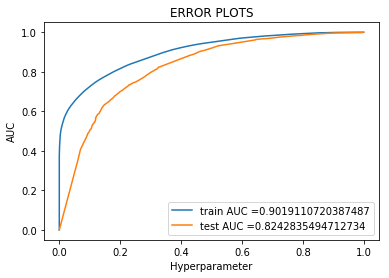

Train confusion matrix
[[ 7656  1091]
 [11652 35601]]
Test confusion matrix
[[ 2959   879]
 [ 5386 14776]]


In [46]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(bowt)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(bowts)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, model.predict(bowt)))
print("Test confusion matrix")
print(confusion_matrix(y_test, model.predict(bowts)))

In [0]:
tr_cv=model.cv_results_['mean_test_score']
ts_cv=model.cv_results_['mean_train_score']

In [0]:
#Creating AUC array

auc_tr=[]
for i in param_grid['max_depth']:
  for j in param_grid['min_samples_split']:
    trauc=auc(train_fpr, train_tpr)
    auc_tr.append(trauc)

In [0]:

auc_ts=[]
for i in param_grid['max_depth']:
  for j in param_grid['min_samples_split']:
    tsauc=auc(test_fpr, test_tpr)
    auc_ts.append(tsauc)

In [0]:
trainp=np.array(auc_tr)
testp=np.array(auc_ts)

In [0]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
Index= len(param_grid['min_samples_split'])
Cols =len(param_grid['max_depth'])
 
# Dataset
df=pd.DataFrame({'X': tr_cv.reshape(Index, Cols), 'Y': trainp.reshape(Index, Cols), 'Z': depth.reshape(Index, Cols)})
 
# plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['X'], df['Y'], df['Z'], c='skyblue', s=60)
ax.view_init(30, 185)
plt.show()


In [0]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random


fig = pyplot.figure()
ax = Axes3D(fig)

sequence_containing_x_vals = list(np.reshape(tr_cv, (2, 3)))
sequence_containing_y_vals = list(auc_tr)
sequence_containing_z_vals = list(depth)

random.shuffle(sequence_containing_x_vals)
random.shuffle(sequence_containing_y_vals)
random.shuffle(sequence_containing_z_vals)

ax.scatter(sequence_containing_x_vals, sequence_containing_y_vals, sequence_containing_z_vals)
pyplot.show()

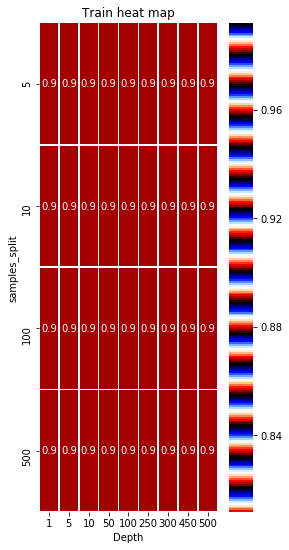

In [51]:

import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

Index= len(param_grid['min_samples_split'])
Cols =len(param_grid['max_depth'])
df = pd.DataFrame(trainp.reshape(Index, Cols), index=param_grid['min_samples_split'], columns= param_grid['max_depth'])
plt.figure(figsize=(Index,Cols))

sns.heatmap(df, cmap='flag', linewidths=0.5, annot=True)
plt.title("Train heat map")
plt.xlabel("Depth")
plt.ylabel("samples_split")
plt.show()



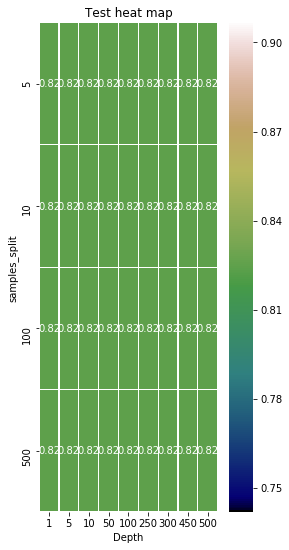

In [52]:
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

Index= len(param_grid['min_samples_split'])
Cols =len(param_grid['max_depth'])
df = pd.DataFrame(testp.reshape(Index, Cols), index=param_grid['min_samples_split'], columns= param_grid['max_depth'])
plt.figure(figsize=(Index,Cols))

sns.heatmap(df, cmap='gist_earth', linewidths=0.2, annot=True)
plt.title("Test heat map")
plt.xlabel("Depth")
plt.ylabel("samples_split")
plt.show()

In [0]:
depth_values = np.arange(2, 60)
auc_values = np.zeros((len(depth_values), 3))
for i, val in enumerate(depth_values):
    test_auc, train_auc = get_aucs(val)
    auc_values[i, 0]  = val
    auc_values[i, 1]  = test_auc
    auc_values[i, 2]  = train_auc

In [0]:
test_auc

0.7551889472953132

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(8,4))
plt.plot(auc_values[:,0], auc_values[:,1], label='Test AUC') 
plt.plot(auc_values[:,0], auc_values[:,2], color='b', label='Train AUC')
plt.legend()
plt.xlabel('Maximum Tree Depth')
plt.ylabel('AUC')

plt.show()

In [0]:
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
import numpy as np

In [0]:
import matplotlib.pyplot as plt 

In [54]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,model.predict(bowts))
cm

array([[ 2959,   879],
       [ 5386, 14776]])

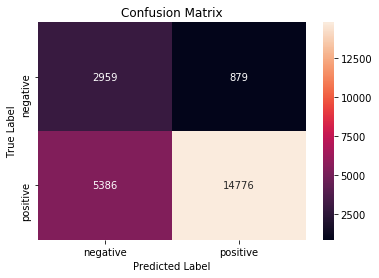

In [55]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [56]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, model.predict(bowt))
cm

array([[ 7656,  1091],
       [11652, 35601]])

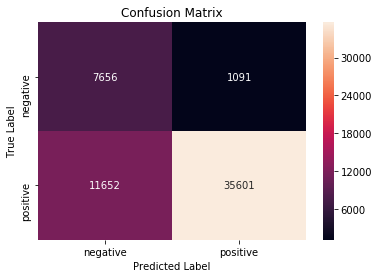

In [57]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

In [0]:
#building with max depth
clf = DecisionTreeClassifier(max_depth = optimal_depth,class_weight = 'balanced')

clf.fit(bowt,y_train)

pred = clf.predict(bowts)

In [0]:
#From Git search 

top20 = np.array(list(map(abs,clf.feature_importances_))).argpartition(-2)[-20:]


In [0]:
Features20={}          
for index in top20:
    for i in count_vect.vocabulary_:
        if count_vect.vocabulary_[i] == index:
            Features20[i]=clf.feature_importances_[index]
            


In [61]:
Features20

{'bad': 0.010800415431449642,
 'best': 0.030147516628256044,
 'delicious': 0.023853038536659668,
 'disappointed': 0.017569275822308696,
 'easy': 0.008007760027855233,
 'excellent': 0.009803041201227786,
 'favorite': 0.008101355394597814,
 'good': 0.019385874720252213,
 'great': 0.06029145548890542,
 'highly': 0.008748598860541919,
 'love': 0.02157022164179838,
 'loves': 0.011722049361552795,
 'not': 0.09423020801164939,
 'perfect': 0.017784780813694123,
 'product': 0.006377166803543019,
 'reviews': 0.007664445333852911,
 'taste': 0.006322430364945982,
 'tasty': 0.006715494438052465,
 'terrible': 0.006859026416781772,
 'would': 0.006347849123976197}

### [5.1.2] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

In [0]:
#https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176
#https://www.kaggle.com/haimfeld87/analysis-and-classification-of-mushrooms
import graphviz
from sklearn import tree

In [0]:

vocab = count_vect.vocabulary_

ind=list(vocab.values())
indexes = np.array(ind).argsort()

words=list(vocab.keys())
Filtered_words=[]
for i in indexes:
    Filtered_words.append(words[i])

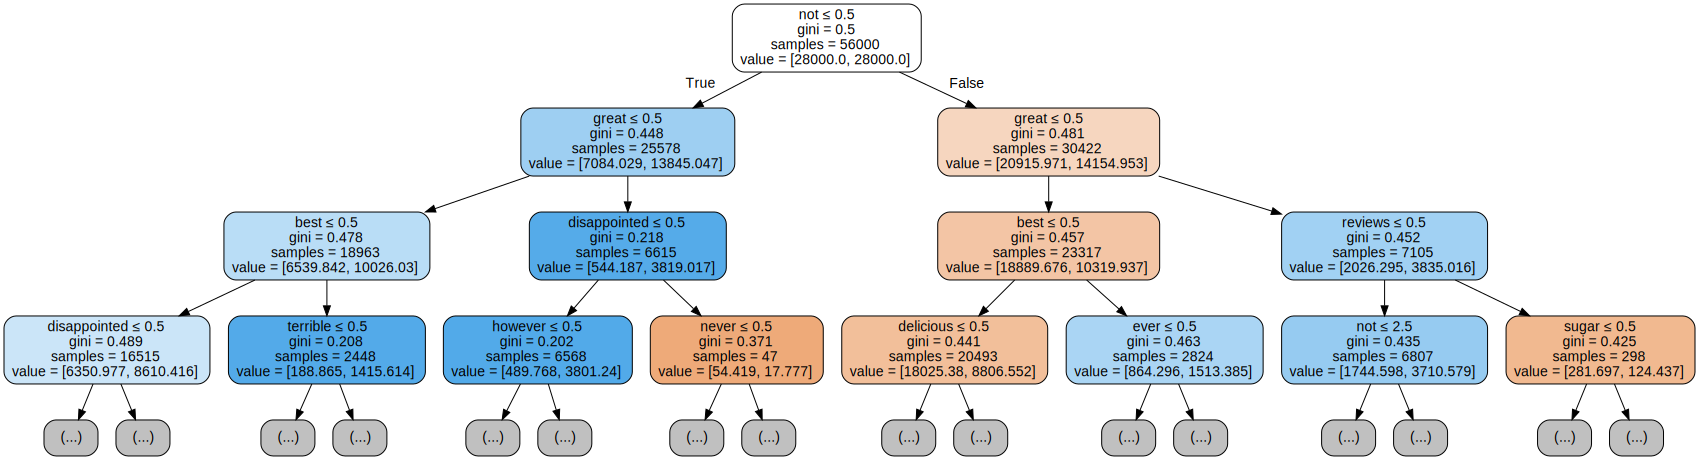

In [64]:
treefig = tree.export_graphviz(clf, out_file=None,max_depth=3,  
                         filled=True, rounded=True,feature_names=Filtered_words,
                         special_characters=True)  
graph = graphviz.Source(treefig) 
graph

## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

In [0]:
#Training the model

depth = [1, 5, 10,25, 50, 100,250]
split=[5, 10, 100,250,350,450,500,550]
clf1 = DecisionTreeClassifier(class_weight ='balanced',random_state=0)
param_grid = {'max_depth':depth,'min_samples_split':split,'criterion':['gini', 'entropy']}
#grid1={'min_samples_split':split}
model1 = GridSearchCV(estimator = clf1,param_grid=param_grid ,cv = 4,n_jobs = 2,scoring='roc_auc')
model1.fit(tfidft, y_train)
print("best depth = ", model1.best_params_)
print("Accuracy on train data = ", model1.best_score_*100)
Features1 = model1.best_params_

best depth =  {'criterion': 'entropy', 'max_depth': 50, 'min_samples_split': 550}
Accuracy on train data =  81.46966550668276


In [0]:
optimal_depth1 = Features1.get('max_depth')
best_split1=Features1.get('min_samples_split')
print(optimal_depth1)

50


In [0]:
#building with max depth
clf1 = DecisionTreeClassifier(max_depth = optimal_depth1,class_weight = 'balanced',min_samples_split=best_split1)

clf1.fit(tfidft,y_train)

pred1 = clf1.predict(tfidfts)

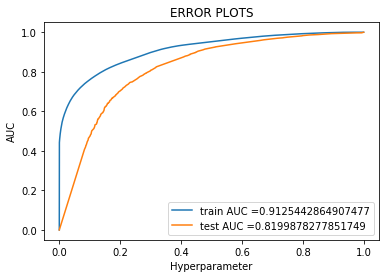

Train confusion matrix
[[ 7642  1120]
 [ 9962 37276]]
Test confusion matrix
[[ 2871   985]
 [ 4746 15398]]


In [0]:
train_fpr1, train_tpr1, thresholds1 = roc_curve(y_train, model1.predict_proba(tfidft)[:,1])
test_fpr1, test_tpr1, thresholds1 = roc_curve(y_test, model1.predict_proba(tfidfts)[:,1])

plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("Hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, model1.predict(tfidft)))
print("Test confusion matrix")
print(confusion_matrix(y_test, model1.predict(tfidfts)))

In [0]:
tr_cv1=model1.cv_results_['mean_test_score']
ts_cv1=model1.cv_results_['mean_train_score']

In [0]:
#Creating AUC array

auc_tr1=[]
for i in param_grid['max_depth']:
  for j in param_grid['min_samples_split']:
    trauc=auc(train_fpr1, train_tpr1)
    auc_tr1.append(trauc)
trainp1=np.array(auc_tr1)
  

In [0]:
auc_ts1=[]
for i in param_grid['max_depth']:
  for j in param_grid['min_samples_split']:
    tsauc=auc(test_fpr1, test_tpr1)
    auc_ts1.append(tsauc)
testp1=np.array(auc_ts1)      

In [0]:
ind=len(param_grid['max_depth'])

col=len(param_grid['min_samples_split'])

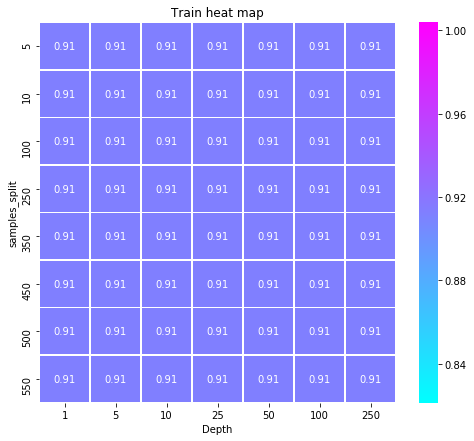

In [0]:
#Train Heatmap
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

Index= len(param_grid['min_samples_split'])
Cols =len(param_grid['max_depth'])
df = pd.DataFrame(trainp1.reshape(Index, Cols), index=param_grid['min_samples_split'], columns= param_grid['max_depth'])
plt.figure(figsize=(Index,Cols))

sns.heatmap(df, cmap='cool', linewidths=0.5, annot=True)
plt.title("Train heat map")
plt.xlabel("Depth")
plt.ylabel("samples_split")
plt.show()



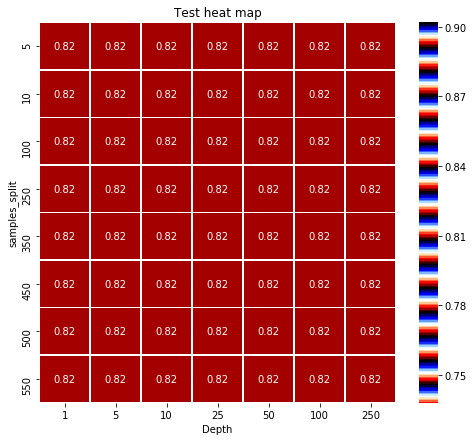

In [0]:
#Train Heatmap
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

Index= len(param_grid['min_samples_split'])
Cols =len(param_grid['max_depth'])
df = pd.DataFrame(testp1.reshape(Index, Cols), index=param_grid['min_samples_split'], columns= param_grid['max_depth'])
plt.figure(figsize=(Index,Cols))

sns.heatmap(df, cmap='flag', linewidths=0.5, annot=True)
plt.title("Test heat map")
plt.xlabel("Depth")
plt.ylabel("samples_split")
plt.show()


In [0]:
depth_tf = np.arange(5, 60)
auc_values = np.zeros((len(depth_tf), 3))
for i, val in enumerate(depth_tf):
    test_auc, train_auc = get_aucstf(val)
    auc_values[i, 0]  = val
    auc_values[i, 1]  = test_auc
    auc_values[i, 2]  = train_auc

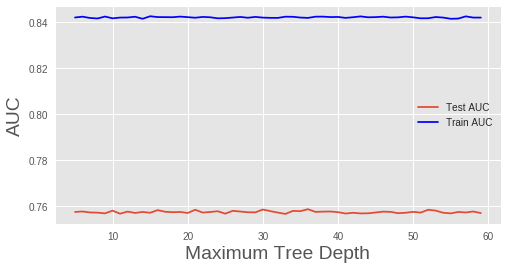

In [0]:
# ggplot can be used to declare the input data frame for a graphic and to specify the set of plot aesthetics intended to be common throughout all subsequent layers unless specifically overridden.
#ggplot is a plotting system for Python based on R's ggplot2
import matplotlib.pyplot as plt
#http://ggplot.yhathq.com/
%matplotlib inline 
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(8,4))
plt.plot(auc_values[:,0], auc_values[:,1], label='Test AUC') 
plt.plot(auc_values[:,0], auc_values[:,2], color='b', label='Train AUC')
plt.legend()
plt.xlabel('Maximum Tree Depth')
plt.ylabel('AUC')

plt.show()

In [0]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(y_test,model1.predict(tfidfts))
cm1

array([[ 2871,   985],
       [ 4746, 15398]])

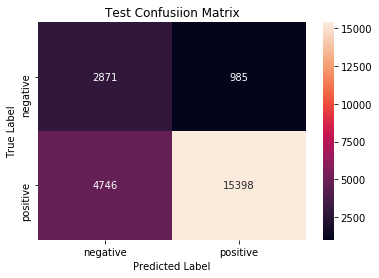

In [0]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm1, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [0]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(y_train,model1.predict(tfidft))
cm1

array([[ 7642,  1120],
       [ 9962, 37276]])

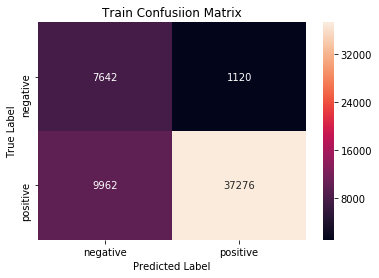

In [0]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm1, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

In [0]:
#building with max depth
clf1 = DecisionTreeClassifier(max_depth = optimal_depth1,class_weight = 'balanced')

clf1.fit(tfidft,y_train)

pred1 = clf1.predict(tfidfts)

In [0]:
#From Git search 

Topfeat = np.array(list(map(abs,clf1.feature_importances_))).argpartition(-2)[-20:]


In [0]:
Toptf={}          
for index in Topfeat:
    for i in tf_idf_vect.vocabulary_:
        if tf_idf_vect.vocabulary_[i] == index:
            Toptf[i]=clf1.feature_importances_[index]
            


In [0]:
Toptf

{'bad': 0.007175221548738761,
 'best': 0.0322328010192486,
 'delicious': 0.023118488345941088,
 'disappointed': 0.02112483339724702,
 'earth best': 0.0019351446386745882,
 'easy': 0.00838531852166141,
 'excellent': 0.008020727386166526,
 'favorite': 0.010585220986008306,
 'good': 0.023183736938476442,
 'great': 0.06837955915953184,
 'love': 0.024515913307553597,
 'loves': 0.01104037175133479,
 'money': 0.00864214256662992,
 'nice': 0.00808966580897957,
 'no': 0.002711176700086357,
 'not': 0.09249105621883945,
 'perfect': 0.017561817705780136,
 'product': 0.006895306008354577,
 'taste': 0.009076571057537947,
 'would': 0.00825903514715423}

### [5.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

In [0]:
import graphviz
from sklearn import tree

In [0]:

vocab1 = tf_idf_vect.vocabulary_

ind=list(vocab1.values())
indexes = np.array(ind).argsort()

words=list(vocab1.keys())
Filtered_words=[]
for i in indexes:
    Filtered_words.append(words[i])

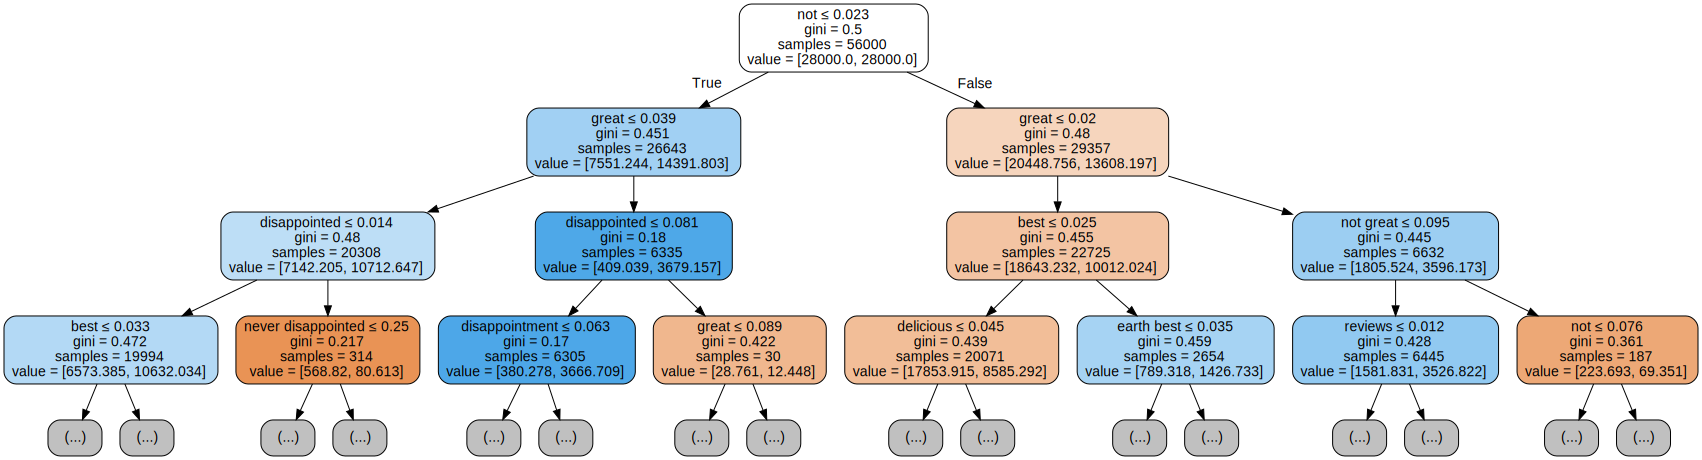

In [0]:
treetf = tree.export_graphviz(clf1, out_file=None,max_depth=3,  
                         filled=True, rounded=True,feature_names=Filtered_words,
                         special_characters=True)  
graph = graphviz.Source(treetf) 
graph

## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation

In [0]:
#Training the model
depth = [1, 5, 10, 50, 100,150,180,230,320,]
split=[5, 10, 100, 250,300,550,600,700]
clf2 = DecisionTreeClassifier(class_weight ='balanced',random_state=0)
param_grid = {'max_depth':depth,'min_samples_split':split,'criterion':['gini','entropy']}

model2 = GridSearchCV(estimator = clf2,param_grid=param_grid ,cv = 10,n_jobs = 3,scoring='roc_auc')
model2.fit(Xavg, y_train)
print("best depth = ", model2.best_params_)
print("Accuracy on train data = ", model2.best_score_*100)
Features2 = model2.best_params_

best depth =  {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 550}
Accuracy on train data =  82.11288085921095


In [0]:
optimal_depth2 = Features2.get('max_depth')
print(optimal_depth2)

10


In [0]:
best_split2=Features2.get('min_samples_split')

In [0]:
#building with max depth
clf2 = DecisionTreeClassifier(max_depth = optimal_depth2,class_weight = 'balanced',min_samples_split=best_split2)

clf2.fit(Xavg,y_train)

pred2 = clf2.predict(Xtsavg)

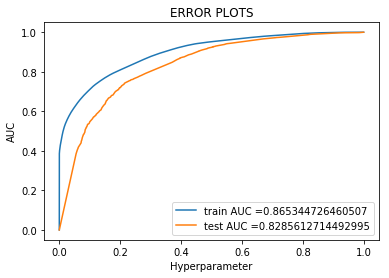

Train confusion matrix
[[ 7322  1440]
 [12803 34435]]
Test confusion matrix
[[ 2999   857]
 [ 5554 14590]]


In [0]:
#AUC curve
train_fpr2, train_tpr2, thresholds2 = roc_curve(y_train, model2.predict_proba(Xavg)[:,1])
test_fpr2, test_tpr2, thresholds2 = roc_curve(y_test, model2.predict_proba(Xtsavg)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr2, train_tpr2)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr2, test_tpr2)))
plt.legend()
plt.xlabel("Hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, model2.predict(Xavg)))
print("Test confusion matrix")
print(confusion_matrix(y_test, model2.predict(Xtsavg)))

In [0]:
tr_cv2=model2.cv_results_['mean_test_score']
ts_cv2=model2.cv_results_['mean_train_score']

In [0]:
#Creating AUC array

auc_tr2=[]
for i in param_grid['max_depth']:
  for j in param_grid['min_samples_split']:
    trauc2=auc(train_fpr2, train_tpr2)
    auc_tr2.append(trauc2)
    
trainaw=np.array(auc_tr2)
 

In [0]:
auc_ts2=[]
for i in param_grid['max_depth']:
  for j in param_grid['min_samples_split']:
    tsauc2=auc(test_fpr2, test_tpr2)
    auc_ts2.append(tsauc2)
testaw=np.array(auc_ts2)      

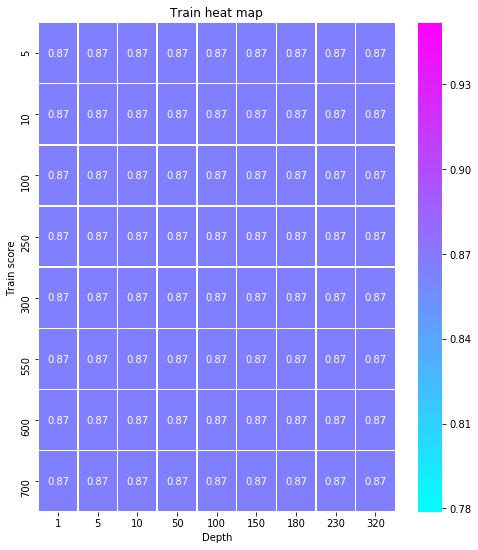

In [0]:
#Train Heatmap
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

Index= len(param_grid['min_samples_split'])
Cols =len(param_grid['max_depth'])
df = pd.DataFrame(trainaw.reshape(Index, Cols), index=param_grid['min_samples_split'], columns= param_grid['max_depth'])
plt.figure(figsize=(Index,Cols))

sns.heatmap(df, cmap='cool', linewidths=0.5, annot=True)
plt.title("Train heat map")
plt.xlabel("Depth")
plt.ylabel("Train score")
plt.show()



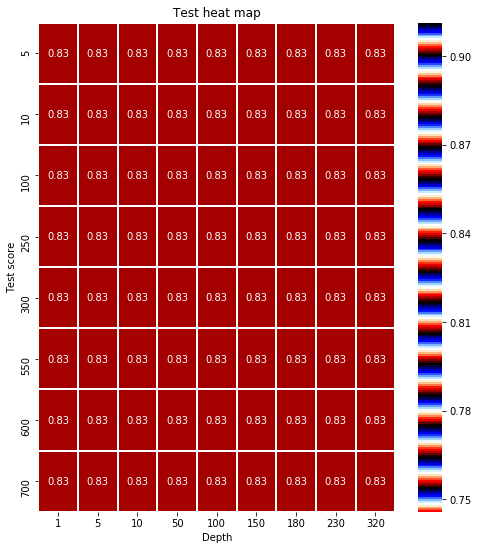

In [0]:
#Train Heatmap
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

Index= len(param_grid['min_samples_split'])
Cols =len(param_grid['max_depth'])
df = pd.DataFrame(testaw.reshape(Index, Cols), index=param_grid['min_samples_split'], columns= param_grid['max_depth'])
plt.figure(figsize=(Index,Cols))

sns.heatmap(df, cmap='flag', linewidths=1, annot=True)
plt.title("Test heat map")
plt.xlabel("Depth")
plt.ylabel("Test score")
plt.show()



In [0]:
#Training with max depth

def get_aucstf(max_depth):
    # Decision trees model with max_depth 
    clf2 = DecisionTreeClassifier(max_depth = optimal_depth2,class_weight = 'balanced')

    clf2.fit(Xavg, y_train)

    # Test AUC
    predictions = clf2.predict(Xtsavg)
    test_auc = roc_auc_score(y_test, predictions)

    # Train AUC
    predictions_train = clf2.predict(Xavg)
    train_auc = roc_auc_score(y_train, predictions_train)
    
    return test_auc, train_auc


In [0]:
depth_avg = np.arange(5, 15)
auc_values = np.zeros((len(depth_avg), 3))
for i, val in enumerate(depth_avg):
    test_auc, train_auc = get_aucstf(val)
    auc_values[i, 0]  = val
    auc_values[i, 1]  = test_auc
    auc_values[i, 2]  = train_auc

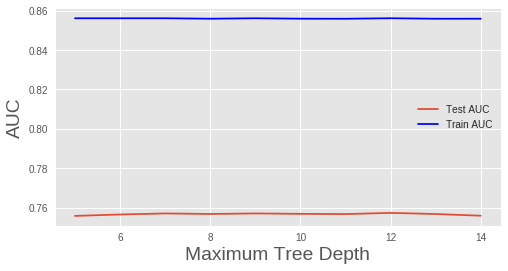

In [0]:
# ggplot can be used to declare the input data frame for a graphic and to specify the set of plot aesthetics intended to be common throughout all subsequent layers unless specifically overridden.
#ggplot is a plotting system for Python based on R's ggplot2
import matplotlib.pyplot as plt
#http://ggplot.yhathq.com/
%matplotlib inline 
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(8,4))
plt.plot(auc_values[:,0], auc_values[:,1], label='Test AUC') 
plt.plot(auc_values[:,0], auc_values[:,2], color='b', label='Train AUC')
plt.legend()
plt.xlabel('Maximum Tree Depth')
plt.ylabel('AUC')

plt.show()

In [0]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm2 = confusion_matrix(y_test,model2.predict(Xtsavg))
cm2

array([[ 2999,   857],
       [ 5554, 14590]])

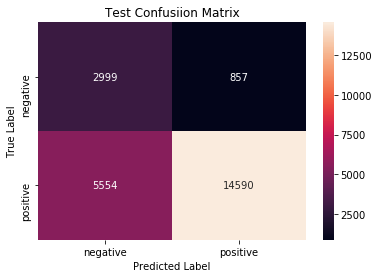

In [0]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm2, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [0]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm2 = confusion_matrix(y_train, model2.predict(Xavg))
cm2

array([[ 7322,  1440],
       [12803, 34435]])

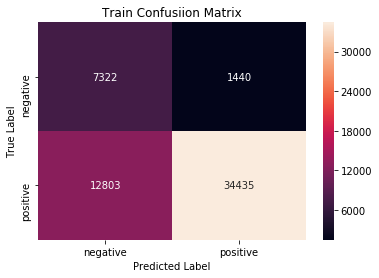

In [0]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm2, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation

In [66]:
#Training the model
depth = [1, 5, 10, 50, 100,250,450,500]
split=[5, 10, 100,400,500,750,900,1000]
clf3 = DecisionTreeClassifier(class_weight ='balanced',random_state=0)
param_grid = {'max_depth':depth,'min_samples_split':split,'criterion':['gini', 'entropy']}

model3 = GridSearchCV(estimator = clf3,param_grid=param_grid ,cv =5,n_jobs =3,scoring='roc_auc')
model3.fit(xtfidf, y_train)
print("best depth = ", model3.best_params_)
print("Accuracy on train data = ", model3.best_score_*100)
Features3 = model3.best_params_

best depth =  {'criterion': 'entropy', 'max_depth': 50, 'min_samples_split': 400}
Accuracy on train data =  79.06679111147274


In [67]:
optimal_depth3 = Features3.get('max_depth')
best_split3=Features3.get('min_samples_split')

print(optimal_depth3)

50


In [0]:
#building with max depth
clf3 = DecisionTreeClassifier(max_depth = optimal_depth3,class_weight = 'balanced',min_samples_split=best_split3)

clf3.fit(xtfidf,y_train)

pred3 = clf3.predict(xtstfidf)

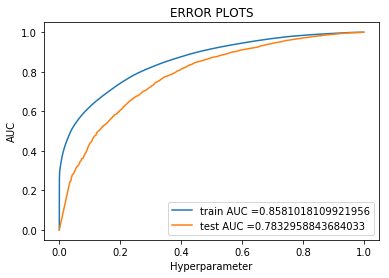

Train confusion matrix
[[ 7021  1726]
 [12331 34922]]
Test confusion matrix
[[ 2713  1125]
 [ 5699 14463]]


In [69]:
train_fpr3, train_tpr3, thresholds3 = roc_curve(y_train, model3.predict_proba(xtfidf)[:,1])
test_fpr3, test_tpr3, thresholds3 = roc_curve(y_test, model3.predict_proba(xtstfidf)[:,1])

plt.plot(train_fpr3, train_tpr3, label="train AUC ="+str(auc(train_fpr3, train_tpr3)))
plt.plot(test_fpr3, test_tpr3, label="test AUC ="+str(auc(test_fpr3, test_tpr3)))
plt.legend()
plt.xlabel("Hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, model3.predict(xtfidf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, model3.predict(xtstfidf)))

In [0]:
tr_cv3=model3.cv_results_['mean_test_score']
ts_cv3=model3.cv_results_['mean_train_score']

In [0]:
#Creating AUC array

auc_tr3=[]
for i in param_grid['max_depth']:
  for j in param_grid['min_samples_split']:
    trauc3=auc(train_fpr3, train_tpr3)
    auc_tr3.append(trauc3)
    
traintwr=np.array(auc_tr3)
 

In [0]:
#Creating AUC array

auc_ts3=[]
for i in param_grid['max_depth']:
  for j in param_grid['min_samples_split']:
    tsauc3=auc(train_fpr3, train_tpr3)
    auc_ts3.append(tsauc3)
    
traintws=np.array(auc_ts3)
 

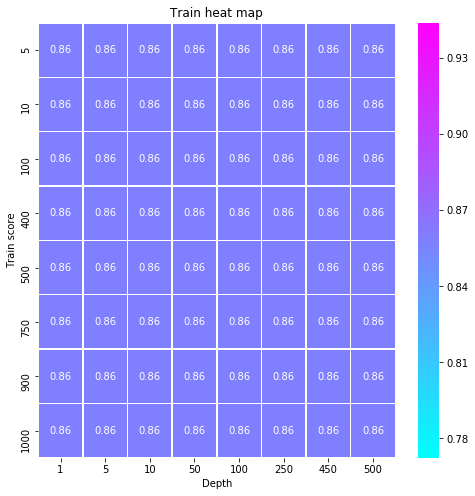

In [73]:
#Train Heatmap
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

Index= len(param_grid['min_samples_split'])
Cols =len(param_grid['max_depth'])
df = pd.DataFrame(traintwr.reshape(Index, Cols), index=param_grid['min_samples_split'], columns= param_grid['max_depth'])
plt.figure(figsize=(Index,Cols))

sns.heatmap(df, cmap='cool', linewidths=0.5, annot=True)
plt.title("Train heat map")
plt.xlabel("Depth")
plt.ylabel("Train score")
plt.show()



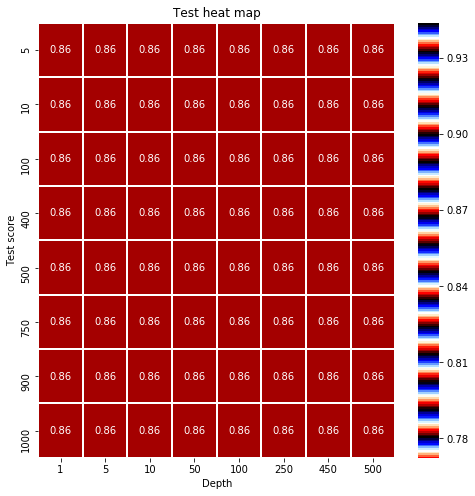

In [74]:
#Train Heatmap
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

Index= len(param_grid['min_samples_split'])
Cols =len(param_grid['max_depth'])
df = pd.DataFrame(traintws.reshape(Index, Cols), index=param_grid['min_samples_split'], columns= param_grid['max_depth'])
plt.figure(figsize=(Index,Cols))

sns.heatmap(df, cmap='flag', linewidths=1, annot=True)
plt.title("Test heat map")
plt.xlabel("Depth")
plt.ylabel("Test score")
plt.show()



In [0]:
depth_tw = np.arange(5, 15)
auc_values = np.zeros((len(depth_tw), 3))
for i, val in enumerate(depth_tw):
    test_auc, train_auc = get_aucstf(val)
    auc_values[i, 0]  = val
    auc_values[i, 1]  = test_auc
    auc_values[i, 2]  = train_auc

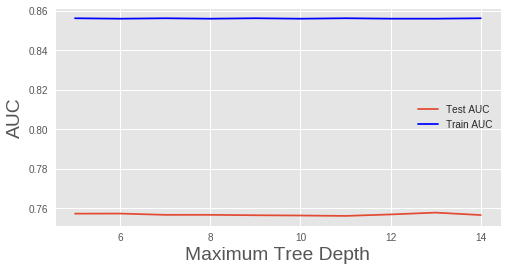

In [0]:
# ggplot can be used to declare the input data frame for a graphic and to specify the set of plot aesthetics intended to be common throughout all subsequent layers unless specifically overridden.
#ggplot is a plotting system for Python based on R's ggplot2
import matplotlib.pyplot as plt
#http://ggplot.yhathq.com/
%matplotlib inline 
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(8,4))
plt.plot(auc_values[:,0], auc_values[:,1], label='Test AUC') 
plt.plot(auc_values[:,0], auc_values[:,2], color='b', label='Train AUC')
plt.legend()
plt.xlabel('Maximum Tree Depth')
plt.ylabel('AUC')

plt.show()

In [0]:

cv_tw = [1-i for i in model3.cv_results_['mean_test_score']]

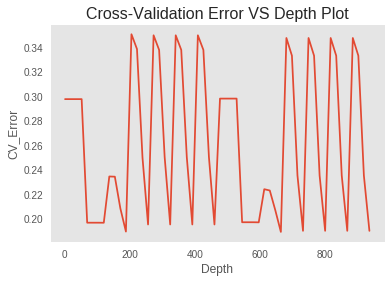

In [0]:
depths=np.arange(1,952,17)
# plotting Cross-Validation Error vs Depth graph 
plt.plot(depths, cv_tw)
plt.xlabel('Depth',size=12)
plt.ylabel('CV_Error',size=12)
plt.title('Cross-Validation Error VS Depth Plot',size=16)
plt.grid()
plt.show()

In [75]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm3 = confusion_matrix(y_train,model3.predict(xtfidf))
cm3

array([[ 7021,  1726],
       [12331, 34922]])

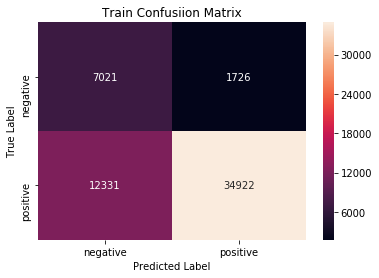

In [76]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm3, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [77]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm3 = confusion_matrix(y_test,model3.predict(xtstfidf))
cm3

array([[ 2713,  1125],
       [ 5699, 14463]])

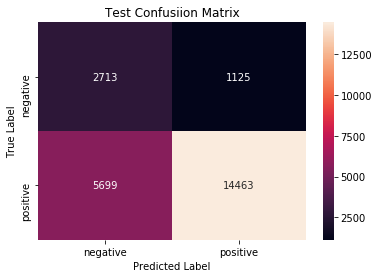

In [78]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm3, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# [6] Conclusions

In [0]:
# Please compare all your models using Prettytable library

In [79]:
#pretty table

from prettytable import PrettyTable
    
p = PrettyTable()

p.field_names = ["Vectoriser model", "Depth", "AUC", ]

p.add_row(["BOW", 50, 0.83,] )
p.add_row(["TFIDF",50 , 0.81,])
p.add_row(["Avg W2V",10 , 0.82,])
p.add_row(["Avg TFIDF W2V", 1, 0.78,])
print(p)

+------------------+-------+------+
| Vectoriser model | Depth | AUC  |
+------------------+-------+------+
|       BOW        |   50  | 0.83 |
|      TFIDF       |   50  | 0.81 |
|     Avg W2V      |   10  | 0.82 |
|  Avg TFIDF W2V   |   1   | 0.78 |
+------------------+-------+------+


**Observations:**

1.   Used Grid search for Hyperparameter training. Given range of numbers to train.
2.  BoW has given best AUC test score.
3.   The results are represented in Pretty table.
4.   Confusion matrix is printed for all the models
5. AUC vs depth plot is plotted.
6.  Overfitting is observed usually descision trees.
7. DT is useful when we have more no of features in dataset.
8. Complexity and expensive calculation is disadvantage of DT. 
9. Heatmap is plotted with Depth vs AUC vs Split .
